In [1]:
# this version accepts all images, both good and bad, the bad ones have labels -1, -1
# this notebook has just quick CNN training
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.__version__

'1.11.0'

In [3]:
img_data = np.load('all_img_data.npy')
img_data.shape

(21852, 64, 64)

In [4]:
lab_data1 = np.load('char1_labels.npy')
lab_data1 += 1 # to shift the -1 labels
print(lab_data1.shape)

(21852,)


In [5]:
lab_data2 = np.load('char2_labels.npy')
lab_data2 += 1
print(lab_data2.shape)

(21852,)


In [6]:
#goodness_data = np.load('goodness_labels.npy')
#goodness_data.shape

In [7]:
#tst1 = np.histogram(lab_data1, bins=25)
#print(tst1)
#tst2 = np.histogram(lab_data2, bins=25)
#print(tst2)

In [8]:
assert(lab_data1.shape[0] == img_data.shape[0] and lab_data1.shape[0] == lab_data2.shape[0])

In [9]:
def vis_data(offset):
   plt.figure(figsize=(10,10))
   for i in range(6*6):
       plt.subplot(6,6,i+1)
       plt.xticks([])
       plt.yticks([])
       plt.grid(False)
       plt.imshow(img_data[offset + i], cmap=plt.cm.gray)
       plt.xlabel(str(lab_data1[offset + i]) + ", " + str(lab_data2[offset + i])) 

In [10]:
# visualize some of the data
#vis_data(0)

In [11]:
# random shuffle to randomly split between test/train samples
total_samples = lab_data1.shape[0]
print(total_samples)
ind_list = [i for i in range(total_samples)]
np.random.shuffle(ind_list)
img_data = img_data[ind_list, :, :]
lab_data1 = lab_data1[ind_list]
lab_data2 = lab_data2[ind_list]
#goodness_data = goodness_data[ind_list]

21852


In [12]:
# visualize some of the data after shuffling
#vis_data(0)

In [13]:
train_samples = 20000
assert(train_samples < total_samples)
test_samples = total_samples - train_samples
train_images = img_data[:train_samples, :, :]
train_labels1 = lab_data1[:train_samples]
train_labels2 = lab_data2[:train_samples]
#train_goodness = goodness_data[:train_samples]

test_images = img_data[train_samples:total_samples, :]
test_labels1 = lab_data1[train_samples:total_samples]
test_labels2 = lab_data2[train_samples:total_samples]
#test_goodness = goodness_data[train_samples:total_samples]

In [14]:
train_images.shape, train_labels1.shape, train_labels2.shape

((20000, 64, 64), (20000,), (20000,))

In [15]:
test_images.shape, test_labels1.shape, test_labels2.shape

((1852, 64, 64), (1852,), (1852,))

In [16]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1) / 255
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1) / 255

In [17]:
np.min(train_images), np.max(train_images)

(0.0, 1.0)

In [18]:
train_images.shape, test_images.shape

((20000, 64, 64, 1), (1852, 64, 64, 1))

In [19]:
np.histogram(test_labels1, bins=25)

(array([1594,    4,    8,   15,   17,   13,   15,   11,    7,   10,   16,
           4,   13,   13,    5,    4,   16,   22,    3,    3,    4,    7,
           7,   11,   30], dtype=int64),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]))

In [20]:
#sess.close()

In [21]:
#define compute graph in tensorflow to evaluate the cost function
tf.reset_default_graph()
rseed2 = 123
np.random.seed(rseed2)
tf.set_random_seed(rseed2)
imgs_ph = tf.placeholder(tf.float32, [None, 64, 64, 1])
labels1_ph = tf.placeholder(tf.int32, [None])
labels2_ph = tf.placeholder(tf.int32, [None])
learnrate_ph = tf.placeholder(tf.float32, None)
training_ph = tf.placeholder(tf.bool)
pkeep_ph = tf.placeholder(tf.float32)

In [22]:
# initialize variables for...
# ... 1) convolution kernels
num_classes = 26

num_filters1 = 12
num_filters2 = 25
num_filters3 = 50
W1 = tf.get_variable("W1", shape=[5, 5, 1, num_filters1], initializer=tf.initializers.glorot_normal())
b1 = tf.get_variable("b1", shape=[num_filters1], initializer=tf.initializers.zeros())
W2 = tf.get_variable("W2", shape=[5, 5, num_filters1, num_filters2], initializer=tf.initializers.glorot_normal())
b2 = tf.get_variable("b2", shape=[num_filters2], initializer=tf.initializers.zeros())
W3 = tf.get_variable("W3", shape=[5, 5, num_filters2, num_filters3], initializer=tf.initializers.glorot_normal())
b3 = tf.get_variable("b3", shape=[num_filters3], initializer=tf.initializers.zeros())

num_fc1 = 800
num_fc2 = 120
num_fc3 = 80
num_fc4 = 50
# ... 2) dense layers: fork 1 (first character prediction)
W4a = tf.get_variable("W4a", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
b4a = tf.get_variable("b4a", shape=[num_fc2], initializer=tf.initializers.zeros())
W5a = tf.get_variable("W5a", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
b5a = tf.get_variable("b5a", shape=[num_fc3], initializer=tf.initializers.zeros())
W6a = tf.get_variable("W6a", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
b6a = tf.get_variable("b6a", shape=[num_fc4], initializer=tf.initializers.zeros())
W7a = tf.get_variable("W7a", shape=[num_fc4, num_classes], initializer=tf.initializers.glorot_normal())
b7a = tf.get_variable("b7a", shape=[num_classes], initializer=tf.initializers.zeros())
# ... 3) dense layers: fork 2 (second character prediction)
W4b = tf.get_variable("W4b", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
b4b = tf.get_variable("b4b", shape=[num_fc2], initializer=tf.initializers.zeros())
W5b = tf.get_variable("W5b", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
b5b = tf.get_variable("b5b", shape=[num_fc3], initializer=tf.initializers.zeros())
W6b = tf.get_variable("W6b", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
b6b = tf.get_variable("b6b", shape=[num_fc4], initializer=tf.initializers.zeros())
# note the num_classes - 1 below:
W7b = tf.get_variable("W7b", shape=[num_fc4, num_classes - 1], initializer=tf.initializers.glorot_normal())
b7b = tf.get_variable("b7b", shape=[num_classes - 1], initializer=tf.initializers.zeros())
#W4c = tf.get_variable("W4c", shape=[num_fc1, num_fc2], initializer=tf.initializers.glorot_normal())
#b4c = tf.get_variable("b4c", shape=[num_fc2], initializer=tf.initializers.zeros())
#W5c = tf.get_variable("W5c", shape=[num_fc2, num_fc3], initializer=tf.initializers.glorot_normal())
#b5c = tf.get_variable("b5c", shape=[num_fc3], initializer=tf.initializers.zeros())
#W6c = tf.get_variable("W6c", shape=[num_fc3, num_fc4], initializer=tf.initializers.glorot_normal())
#b6c = tf.get_variable("b6c", shape=[num_fc4], initializer=tf.initializers.zeros())
#W7c = tf.get_variable("W7c", shape=[num_fc4, 1], initializer=tf.initializers.glorot_normal())
#b7c = tf.get_variable("b7c", shape=[1], initializer=tf.initializers.zeros())

In [23]:
assert(num_classes == max(lab_data1) + 1)

In [24]:
# build compute graph evaluating the CNN
conv1 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(imgs_ph, W1, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv1 = tf.nn.relu(tf.nn.conv2d(imgs_ph, W1, strides = [1,1,1,1], padding = 'VALID'))
pool1 = tf.nn.dropout(tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
conv2 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(pool1, W2, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv2 = tf.nn.relu(tf.nn.conv2d(pool1, W2, strides = [1,1,1,1], padding = 'VALID'))
pool2 = tf.nn.dropout(tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
conv3 = tf.nn.relu(tf.layers.batch_normalization(tf.nn.conv2d(pool2, W3, strides = [1,1,1,1], padding = 'VALID'), 
                                                 axis=[1,2,3], training=training_ph))
#conv3 = tf.nn.relu(tf.nn.conv2d(pool2, W3, strides = [1,1,1,1], padding = 'VALID'))
pool3 = tf.nn.dropout(tf.nn.max_pool(conv3, ksize = [1,2,2,1], strides=[1,2,2,1], padding = 'VALID'), pkeep_ph)
flat1 = tf.reshape(pool3, [-1, num_fc1])
bnorm_axis = -1
dens1a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(flat1, W4a), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens2a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens1a, W5a), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens3a = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens2a, W6a), axis=bnorm_axis, training=training_ph)), 1.0)
dens4a = tf.layers.batch_normalization(tf.matmul(dens3a, W7a), axis=bnorm_axis, training=training_ph)

dens1b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(flat1, W4b), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens2b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens1b, W5b), axis=bnorm_axis, training=training_ph)), pkeep_ph)
dens3b = tf.nn.dropout(tf.nn.relu(tf.layers.batch_normalization(
    tf.matmul(dens2b, W6b), axis=bnorm_axis, training=training_ph)), 1.0)
dens4b_partial = tf.layers.batch_normalization(tf.matmul(dens3b, W7b), axis=bnorm_axis, training=training_ph)
# hack: copy the first column of dens4a into dens4b
d4a_s1, d4a_s2 = tf.split(dens4a, [1,25], 1)
dens4b = tf.concat([d4a_s1, dens4b_partial], axis=1)

#crent = tf.nn.sigmoid_cross_entropy_with_logits(labels = goodness_ph, logits = dens4c)
crenta = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels1_ph, logits = dens4a)
crentb = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels2_ph, logits = dens4b)
crent = crenta + crentb
loss_fun = tf.reduce_mean(crent)
# for batch-norm updates:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate = learnrate_ph).minimize(loss_fun)

predictions1 = tf.equal(tf.argmax(dens4a, 1), tf.cast(labels1_ph, tf.int64))
predictions2 = tf.equal(tf.argmax(dens4b, 1), tf.cast(labels2_ph, tf.int64))
predictions = tf.logical_and(predictions1, predictions2)
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))
#predictions_goodness = tf.math.greater(dens4c, 0.0)
#correct_preds_g = tf.equal(predictions_goodness, tf.cast(goodness_ph, tf.bool))
#accuracy = tf.reduce_mean(tf.cast(correct_preds_g, tf.float32))

In [25]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [26]:
batch_size = 400
learning_rate = 0.001
num_batches = int(train_images.shape[0] / batch_size)
print('num_batches =', num_batches)
# discard training data that overflow the last minibatch
trunc_train_images = train_images[:num_batches*batch_size,:,:,:]
trunc_train_labels1 = train_labels1[:num_batches*batch_size]
trunc_train_labels2 = train_labels2[:num_batches*batch_size]
#trunc_train_goodness = train_goodness[:num_batches*batch_size]

num_batches = 50


In [27]:
def train(num_epochs, learning_rate = 0.001, pkeep = 0.75):
    global trunc_train_images, trunc_train_labels1, trunc_train_labels2
    for e in range(num_epochs):
        # randomize the order of training data
        ind_list = [i for i in range(trunc_train_images.shape[0])]
        np.random.shuffle(ind_list)
        trunc_train_images = trunc_train_images[ind_list, :, :, :]
        trunc_train_labels1 = trunc_train_labels1[ind_list]
        trunc_train_labels2 = trunc_train_labels2[ind_list]
        #trunc_train_goodness = trunc_train_goodness[ind_list]

        start_time = time.time()
        for i in range(num_batches):        
            train_dict = {imgs_ph:trunc_train_images[i*batch_size:(i+1)*batch_size,:,:,:], 
                          labels1_ph:trunc_train_labels1[i*batch_size:(i+1)*batch_size],
                          labels2_ph:trunc_train_labels2[i*batch_size:(i+1)*batch_size],
                          learnrate_ph:learning_rate,
                          training_ph:True,
                          pkeep_ph:pkeep}                          
            sess.run(train_step, train_dict)
            #print(e, '/', i)
            # the following stats compute can be removed to speed up training
            #mb_loss, mb_acc = sess.run([loss_fun, accuracy], train_dict)    
            #print(e, '/', i, ': mb_loss = ', mb_loss, ' mb_acc = ', mb_acc)

        loss_train, acc_train = 0.0, 0.0
        for i in range(num_batches):    
            train_dict = {imgs_ph:trunc_train_images[i*batch_size:(i+1)*batch_size,:,:,:], 
                          labels1_ph:trunc_train_labels1[i*batch_size:(i+1)*batch_size],
                          labels2_ph:trunc_train_labels2[i*batch_size:(i+1)*batch_size],
                          learnrate_ph:learning_rate,
                          training_ph:False, pkeep_ph:1.0}
            l_train, a_train = sess.run([loss_fun, accuracy], train_dict)    
            loss_train += l_train
            acc_train += a_train
        end_time = time.time()
        elaps_time = end_time - start_time

        loss_train /= num_batches
        acc_train /= num_batches

        # also compute loss & accuracy on the test set, no need to minibatch that 
        loss_test, acc_test = sess.run([loss_fun, accuracy], {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels2, learnrate_ph:learning_rate, training_ph:False, pkeep_ph:1.0})

        print("%03i (%.2f): ltr = %.6f, atr = %.6f | lts = %.6f, ats = %.6f" % (e, elaps_time, loss_train, acc_train, loss_test, acc_test))
        #print(e, ': loss_train =', loss_train, ' acc_train =', acc_train, 'time =', end_time - start_time)

In [28]:
train(40)

000 (7.69): ltr = 5.403993, atr = 0.850650 | lts = 5.390155, ats = 0.860691
001 (5.20): ltr = 4.805232, atr = 0.850550 | lts = 4.784583, ats = 0.860151
002 (5.14): ltr = 4.599517, atr = 0.848800 | lts = 4.579761, ats = 0.857451
003 (5.19): ltr = 4.443801, atr = 0.839200 | lts = 4.444236, ats = 0.845032
004 (5.19): ltr = 4.206810, atr = 0.846600 | lts = 4.208642, ats = 0.850432
005 (5.13): ltr = 3.869081, atr = 0.887100 | lts = 3.879885, ats = 0.884989
006 (5.14): ltr = 3.584129, atr = 0.908400 | lts = 3.607499, ats = 0.906587
007 (5.15): ltr = 3.320078, atr = 0.928300 | lts = 3.356503, ats = 0.923326
008 (5.14): ltr = 3.167912, atr = 0.929400 | lts = 3.182632, ats = 0.929266
009 (5.15): ltr = 2.808276, atr = 0.947300 | lts = 2.866080, ats = 0.943844
010 (5.13): ltr = 2.591098, atr = 0.955850 | lts = 2.659822, ats = 0.950324
011 (5.14): ltr = 2.421524, atr = 0.962300 | lts = 2.483599, ats = 0.954104
012 (5.20): ltr = 2.254720, atr = 0.968600 | lts = 2.333725, ats = 0.960043
013 (5.22): 

In [29]:
train(40, 0.0003)

000 (5.23): ltr = 0.343925, atr = 0.996850 | lts = 0.433466, ats = 0.987041
001 (5.43): ltr = 0.348280, atr = 0.996750 | lts = 0.446303, ats = 0.987041
002 (5.19): ltr = 0.349006, atr = 0.996700 | lts = 0.419779, ats = 0.984341
003 (5.33): ltr = 0.350395, atr = 0.997100 | lts = 0.432195, ats = 0.986501
004 (5.35): ltr = 0.334618, atr = 0.997250 | lts = 0.417868, ats = 0.985961
005 (5.25): ltr = 0.335535, atr = 0.997350 | lts = 0.417029, ats = 0.988121
006 (5.41): ltr = 0.317069, atr = 0.997550 | lts = 0.407225, ats = 0.988121
007 (5.41): ltr = 0.310092, atr = 0.997450 | lts = 0.405292, ats = 0.988121
008 (5.39): ltr = 0.318116, atr = 0.997400 | lts = 0.402221, ats = 0.987041
009 (5.26): ltr = 0.308175, atr = 0.997550 | lts = 0.391310, ats = 0.987041
010 (5.23): ltr = 0.313099, atr = 0.996950 | lts = 0.428018, ats = 0.987581
011 (5.29): ltr = 0.297547, atr = 0.997250 | lts = 0.413195, ats = 0.988661
012 (5.39): ltr = 0.295604, atr = 0.997400 | lts = 0.401931, ats = 0.988121
013 (5.17): 

KeyboardInterrupt: 

In [43]:
train(10, 0.0001)

000 (5.09): ltr = 0.204661, atr = 0.998850 | lts = 0.285835, ats = 0.990281
001 (5.19): ltr = 0.206163, atr = 0.998500 | lts = 0.306034, ats = 0.989201
002 (5.29): ltr = 0.210441, atr = 0.998650 | lts = 0.296643, ats = 0.989741
003 (5.23): ltr = 0.208225, atr = 0.998500 | lts = 0.294561, ats = 0.989201
004 (5.29): ltr = 0.202044, atr = 0.998250 | lts = 0.324757, ats = 0.988121
005 (5.16): ltr = 0.198582, atr = 0.998650 | lts = 0.300474, ats = 0.989201
006 (5.16): ltr = 0.199783, atr = 0.998900 | lts = 0.287520, ats = 0.988661
007 (5.16): ltr = 0.195482, atr = 0.998650 | lts = 0.277109, ats = 0.988661
008 (5.37): ltr = 0.197082, atr = 0.998650 | lts = 0.294389, ats = 0.988661
009 (5.20): ltr = 0.195636, atr = 0.998850 | lts = 0.282271, ats = 0.988661


In [45]:
train(40, 0.0003)

000 (5.17): ltr = 0.184464, atr = 0.998150 | lts = 0.257327, ats = 0.990281
001 (5.28): ltr = 0.165072, atr = 0.998800 | lts = 0.249235, ats = 0.991361


KeyboardInterrupt: 

In [46]:
# next double check if the test accuracy is correct:

In [47]:
t_dens4a = sess.run(dens4a, {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels1, training_ph:False, pkeep_ph:1.0})

In [48]:
t_predictions1 = np.argmax(t_dens4a, 1)

In [49]:
t_predictions1.shape, test_images.shape[0]

((1852,), 1852)

In [50]:
t_dens4b = sess.run(dens4b, {imgs_ph:test_images, labels1_ph:test_labels1, labels2_ph:test_labels1, training_ph:False, pkeep_ph:1.0})

In [51]:
t_predictions2 = np.argmax(t_dens4b, 1)

In [52]:
t_predictions2

array([ 0,  0,  0, ...,  0,  0, 11], dtype=int64)

In [53]:
count = 0
for i in range(test_images.shape[0]):    
    if t_predictions1[i] == test_labels1[i] and t_predictions2[i] == test_labels2[i]:
        count = count + 1
print(float(count) / test_images.shape[0])

0.9897408207343412


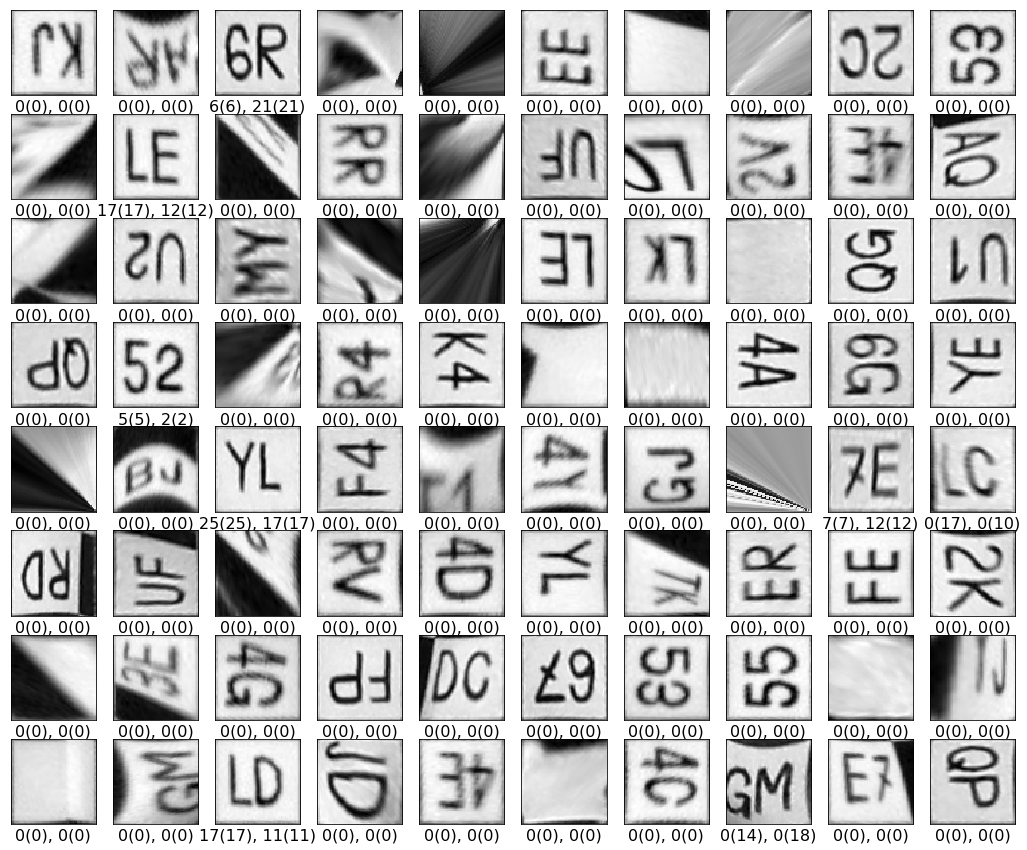

In [54]:
# visualize the predictions
offset = 80
plt.figure(figsize=(18,15))
for i in range(10*8):
    plt.subplot(8,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(test_images[offset + i, :, :, 0], cmap=plt.cm.gray)
    #plt.xlabel(str(t_predictions1[offset + i]) + ", " + str(t_predictions2[offset + i])) 
    plt.xlabel("%i(%i), %i(%i)" % (t_predictions1[offset + i], test_labels1[offset + i],
                                   t_predictions2[offset + i], test_labels2[offset + i]), fontsize = 16)

In [55]:
# select incorrect predictions
err_imgs = []
err_str = []
for i in range(test_images.shape[0]):    
    if t_predictions1[i] == test_labels1[i] and t_predictions2[i] == test_labels2[i]:
        None
    else:
        err_imgs.append(test_images[i, :, :, 0])
        err_str.append("%i(%i), %i(%i)" % (t_predictions1[i], test_labels1[i], t_predictions2[i], test_labels2[i]))
print(len(err_imgs))

19


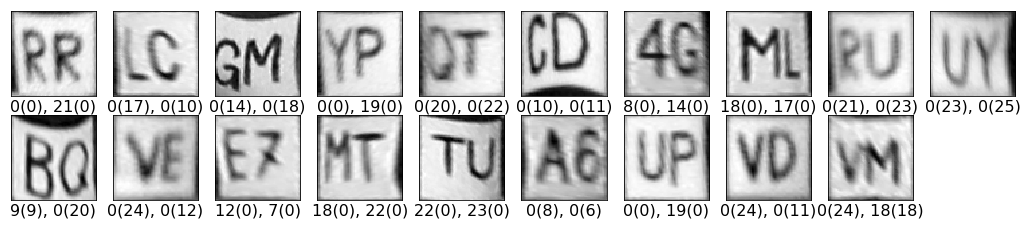

In [56]:
# visualize them
plt.figure(figsize=(18,15))
for i in range(len(err_imgs)):
    plt.subplot(8,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(err_imgs[i], cmap=plt.cm.gray)    
    plt.xlabel(err_str[i], fontsize = 16)

In [57]:
saver = tf.train.Saver()
save_path = saver.save(sess, ".\CNN_2char_bn_unified.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: .\CNN_2char_bn_unified.ckpt


In [ ]:
sess.close()